In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter   # For smoothing


In [2]:
# 1) LOAD DATA

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# 2) FILTER ONLY 3 CLASSES

# Bag = 8 , Trouser = 1 , Sneaker = 7
keep_classes = [8, 1, 7]

train_mask = np.isin(y_train, keep_classes)
test_mask = np.isin(y_test, keep_classes)

X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

In [4]:
## PREPROCESSING

# A) Normalize to [0,1]
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# B) Remove noise using Gaussian smoothing
X_train_smooth = np.array([gaussian_filter(img, sigma=0.7) for img in X_train_norm])
X_test_smooth  = np.array([gaussian_filter(img, sigma=0.7) for img in X_test_norm])

# C) Flatten
X_train_flat = X_train_smooth.reshape(-1, 784)
X_test_flat = X_test_smooth.reshape(-1, 784)

# D) Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

print("Train size:", X_train_final.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test_scaled.shape)

Train size: (18000, 28, 28)
Test size: (3000, 28, 28)
Train size: (14400, 784)
Validation size: (3600, 784)
Test size: (3000, 784)


In [9]:
# 4) LOGISTIC REGRESSION
import warnings
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    multi_class="multinomial"
)

log_reg.fit(X_train_final, y_train_final)

# Predictions
y_train_pred = log_reg.predict(X_train_final)
y_val_pred   = log_reg.predict(X_val)
y_test_pred  = log_reg.predict(X_test_scaled)

print("\nLogistic Regression Train Acc:", accuracy_score(y_train_final, y_train_pred))
print("Logistic Regression Validation Acc:", accuracy_score(y_val, y_val_pred))  # << جديد
print("Logistic Regression Test Acc :", accuracy_score(y_test, y_test_pred))

c:\Users\ok\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Train Acc: 0.9999305555555555
Logistic Regression Validation Acc: 0.9947222222222222
Logistic Regression Test Acc : 0.994


In [10]:
# 5) K-MEANS
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_final)

clusters_val = kmeans.predict(X_val)
clusters_test = kmeans.predict(X_test_scaled)

# Map cluster -> class (train clusters)
label_map = {}
for cluster in range(3):
    labels = y_train_final[kmeans.labels_ == cluster]
    label_map[cluster] = np.bincount(labels).argmax() if len(labels) > 0 else 0

# Predictions for validation and test
y_val_pred_kmeans  = np.array([label_map[c] for c in clusters_val])    # << جديد
y_test_pred_kmeans = np.array([label_map[c] for c in clusters_test])

print("\nK-Means Validation Accuracy:", accuracy_score(y_val, y_val_pred_kmeans))  # << جديد
print("K-Means Test Accuracy:", accuracy_score(y_test, y_test_pred_kmeans))


K-Means Validation Accuracy: 0.9161111111111111
K-Means Test Accuracy: 0.9163333333333333


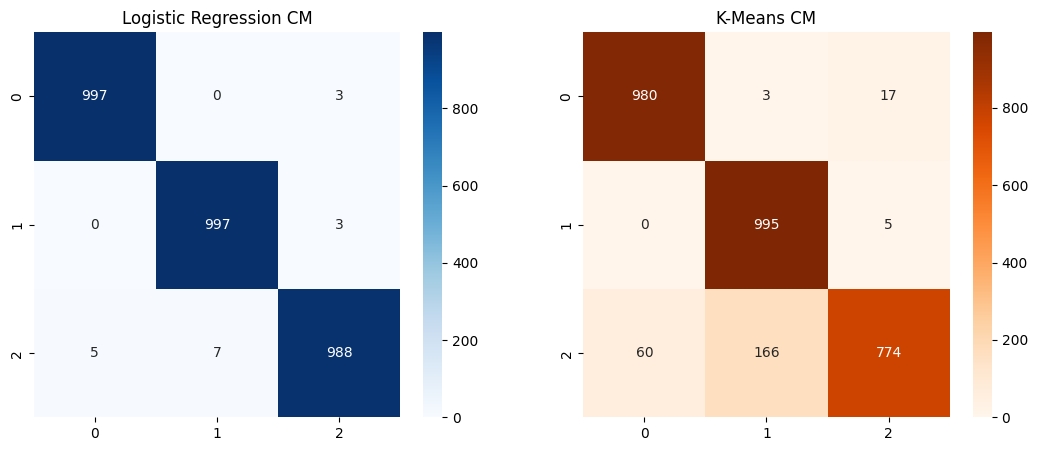

In [11]:

# 6) CONFUSION MATRICES
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_test_pred), cmap="Blues", annot=True, fmt="d")
plt.title("Logistic Regression CM")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_test_pred_kmeans), cmap="Oranges", annot=True, fmt="d")
plt.title("K-Means CM")

plt.show()

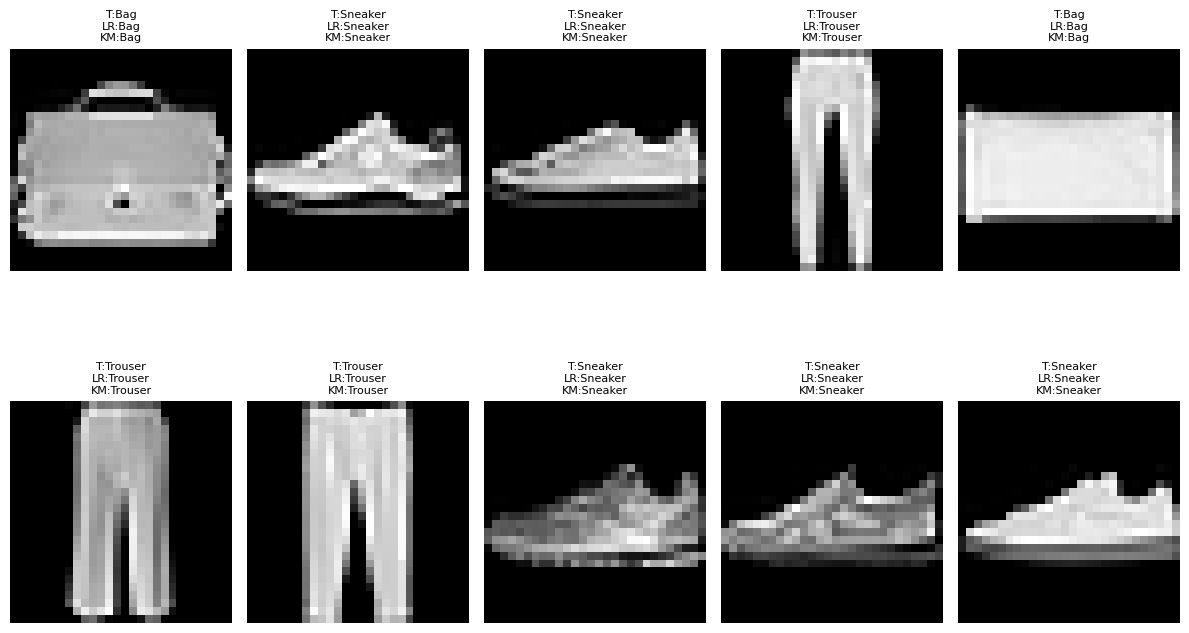

In [13]:
# 7) VISUALIZE PREDICTIONS
class_names = {8: "Bag", 1: "Trouser", 7: "Sneaker"}
# 7) VISUALIZE PREDICTIONS
class_names = {8: "Bag", 1: "Trouser", 7: "Sneaker"}

plt.figure(figsize=(12,8))
for i in range(10):
    idx = np.random.randint(0, len(X_test_scaled))
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.axis('off')

    true_lbl = class_names[y_test[idx]]
    lr_lbl = class_names[y_test_pred[idx]]
    km_lbl = class_names[y_test_pred_kmeans[idx]]

    plt.title(f"T:{true_lbl}\nLR:{lr_lbl}\nKM:{km_lbl}", fontsize=8)

plt.tight_layout()
plt.show()